# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [5e-4,1e-3,5e-3]
regularization_strengths = [0.1,2,10]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for rate in learning_rates:
    for strength in regularization_strengths:
        clf = LinearSVM()
        loss_hist = clf.train(X_train_feats, y_train, learning_rate=rate, reg=strength,
                      num_iters=10000, verbose=True)
        y_train_pred = clf.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = clf.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(rate,strength)] = (train_accuracy,val_accuracy)
        if (val_accuracy > best_val):
            best_val = val_accuracy
            best_svm = clf
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 10000: loss 8.994648
iteration 100 / 10000: loss 5.947641
iteration 200 / 10000: loss 4.644404
iteration 300 / 10000: loss 4.455405
iteration 400 / 10000: loss 4.101545
iteration 500 / 10000: loss 3.711030
iteration 600 / 10000: loss 4.246331
iteration 700 / 10000: loss 3.980417
iteration 800 / 10000: loss 3.407979
iteration 900 / 10000: loss 3.254642
iteration 1000 / 10000: loss 3.417417
iteration 1100 / 10000: loss 3.723481
iteration 1200 / 10000: loss 3.927707
iteration 1300 / 10000: loss 3.319342
iteration 1400 / 10000: loss 3.398999
iteration 1500 / 10000: loss 3.567751
iteration 1600 / 10000: loss 3.358715
iteration 1700 / 10000: loss 3.060465
iteration 1800 / 10000: loss 3.102923
iteration 1900 / 10000: loss 3.320805
iteration 2000 / 10000: loss 3.552541
iteration 2100 / 10000: loss 3.396346
iteration 2200 / 10000: loss 2.817214
iteration 2300 / 10000: loss 3.111082
iteration 2400 / 10000: loss 2.992988
iteration 2500 / 10000: loss 3.056506
iteration 2600 / 10000: 

iteration 1800 / 10000: loss 3.778134
iteration 1900 / 10000: loss 3.164436
iteration 2000 / 10000: loss 3.353612
iteration 2100 / 10000: loss 3.393168
iteration 2200 / 10000: loss 2.984228
iteration 2300 / 10000: loss 2.771022
iteration 2400 / 10000: loss 3.287243
iteration 2500 / 10000: loss 3.242823
iteration 2600 / 10000: loss 2.621183
iteration 2700 / 10000: loss 3.247543
iteration 2800 / 10000: loss 3.402217
iteration 2900 / 10000: loss 3.249554
iteration 3000 / 10000: loss 3.550764
iteration 3100 / 10000: loss 3.311700
iteration 3200 / 10000: loss 3.425964
iteration 3300 / 10000: loss 2.982365
iteration 3400 / 10000: loss 3.345452
iteration 3500 / 10000: loss 2.826536
iteration 3600 / 10000: loss 2.655135
iteration 3700 / 10000: loss 3.055691
iteration 3800 / 10000: loss 3.068352
iteration 3900 / 10000: loss 3.015001
iteration 4000 / 10000: loss 2.713384
iteration 4100 / 10000: loss 3.209228
iteration 4200 / 10000: loss 2.934060
iteration 4300 / 10000: loss 2.850793
iteration 44

iteration 3500 / 10000: loss 2.842587
iteration 3600 / 10000: loss 2.501635
iteration 3700 / 10000: loss 2.927284
iteration 3800 / 10000: loss 2.954285
iteration 3900 / 10000: loss 2.902699
iteration 4000 / 10000: loss 3.149311
iteration 4100 / 10000: loss 2.840233
iteration 4200 / 10000: loss 2.535921
iteration 4300 / 10000: loss 2.766833
iteration 4400 / 10000: loss 2.741470
iteration 4500 / 10000: loss 2.953014
iteration 4600 / 10000: loss 2.882549
iteration 4700 / 10000: loss 2.823369
iteration 4800 / 10000: loss 2.954903
iteration 4900 / 10000: loss 2.881586
iteration 5000 / 10000: loss 2.708240
iteration 5100 / 10000: loss 2.989435
iteration 5200 / 10000: loss 2.563451
iteration 5300 / 10000: loss 3.261001
iteration 5400 / 10000: loss 3.289284
iteration 5500 / 10000: loss 2.846999
iteration 5600 / 10000: loss 2.682225
iteration 5700 / 10000: loss 3.283000
iteration 5800 / 10000: loss 3.356806
iteration 5900 / 10000: loss 2.731639
iteration 6000 / 10000: loss 2.937236
iteration 61

iteration 5200 / 10000: loss 2.828669
iteration 5300 / 10000: loss 2.861856
iteration 5400 / 10000: loss 2.933651
iteration 5500 / 10000: loss 2.781539
iteration 5600 / 10000: loss 3.054355
iteration 5700 / 10000: loss 2.927003
iteration 5800 / 10000: loss 2.885511
iteration 5900 / 10000: loss 2.882624
iteration 6000 / 10000: loss 2.972931
iteration 6100 / 10000: loss 2.590000
iteration 6200 / 10000: loss 3.198983
iteration 6300 / 10000: loss 3.011636
iteration 6400 / 10000: loss 2.921521
iteration 6500 / 10000: loss 2.872759
iteration 6600 / 10000: loss 2.698969
iteration 6700 / 10000: loss 2.561207
iteration 6800 / 10000: loss 3.316336
iteration 6900 / 10000: loss 2.775768
iteration 7000 / 10000: loss 2.796852
iteration 7100 / 10000: loss 2.805032
iteration 7200 / 10000: loss 3.261601
iteration 7300 / 10000: loss 3.223652
iteration 7400 / 10000: loss 2.846406
iteration 7500 / 10000: loss 2.734981
iteration 7600 / 10000: loss 3.349175
iteration 7700 / 10000: loss 3.064875
iteration 78

iteration 7000 / 10000: loss 3.277741
iteration 7100 / 10000: loss 3.061965
iteration 7200 / 10000: loss 2.811071
iteration 7300 / 10000: loss 2.897700
iteration 7400 / 10000: loss 2.786379
iteration 7500 / 10000: loss 3.025156
iteration 7600 / 10000: loss 3.009314
iteration 7700 / 10000: loss 2.958469
iteration 7800 / 10000: loss 2.970289
iteration 7900 / 10000: loss 3.020158
iteration 8000 / 10000: loss 3.087903
iteration 8100 / 10000: loss 3.592228
iteration 8200 / 10000: loss 3.222599
iteration 8300 / 10000: loss 2.575098
iteration 8400 / 10000: loss 3.470732
iteration 8500 / 10000: loss 2.870883
iteration 8600 / 10000: loss 3.353283
iteration 8700 / 10000: loss 3.035348
iteration 8800 / 10000: loss 2.928136
iteration 8900 / 10000: loss 2.758251
iteration 9000 / 10000: loss 2.726403
iteration 9100 / 10000: loss 2.628127
iteration 9200 / 10000: loss 2.951591
iteration 9300 / 10000: loss 2.896529
iteration 9400 / 10000: loss 3.049466
iteration 9500 / 10000: loss 2.558163
iteration 96

In [5]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.485


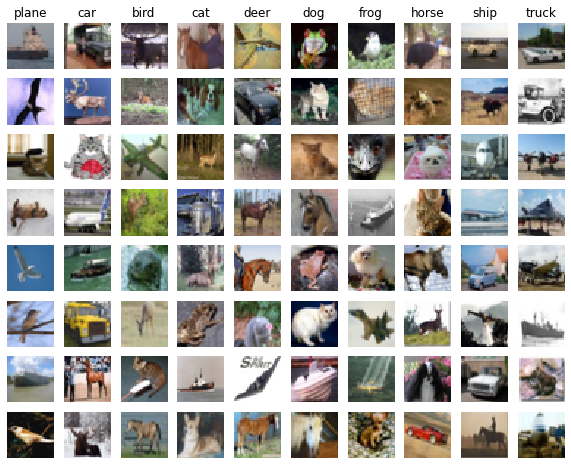

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$

错误的分类结果与对应类别的图像特征较为相似，例如HOG便是提取对应位置梯度，HOG特征与其他类相似的便有可能被错误分类。


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [8]:
from cs231n.classifiers.neural_net import TwoLayerNet

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
results = {}
bestacc = 0
input_size = X_train_feats.shape[1]
hidden_size = 1536
learning_rate = [1]
regularization_strengths = [1e-3]
num_classes = 10
for lr in learning_rate:
    for reg in regularization_strengths:
        net = TwoLayerNet(input_size, hidden_size, num_classes)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=3000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.85,
                reg=reg, verbose=True)
        results[(lr,reg)] = (stats['train_acc_history'][-1],stats['val_acc_history'][-1])
        print ('train accuracy: %.4f' %stats['train_acc_history'][-1])
        print ('validation accuracy: %.4f' %stats['val_acc_history'][-1])
        if (stats['val_acc_history'][-1]>bestacc):
            bestacc = stats['val_acc_history'][-1]
            best_net = net
        
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
pass
print('best validation accuracy achieved during cross-validation: %f' % bestacc)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 3000: loss 2.302586
iteration 100 / 3000: loss 1.437732
iteration 200 / 3000: loss 1.373503
iteration 300 / 3000: loss 1.262439
iteration 400 / 3000: loss 1.384252
iteration 500 / 3000: loss 1.172199
iteration 600 / 3000: loss 1.092525
iteration 700 / 3000: loss 1.145833
iteration 800 / 3000: loss 1.258821
iteration 900 / 3000: loss 1.190587
iteration 1000 / 3000: loss 1.103155
iteration 1100 / 3000: loss 1.059467
iteration 1200 / 3000: loss 1.069209
iteration 1300 / 3000: loss 0.966599
iteration 1400 / 3000: loss 0.952986
iteration 1500 / 3000: loss 0.895750
iteration 1600 / 3000: loss 0.943565
iteration 1700 / 3000: loss 0.935176
iteration 1800 / 3000: loss 0.943635
iteration 1900 / 3000: loss 0.813221
iteration 2000 / 3000: loss 0.943747
iteration 2100 / 3000: loss 0.835734
iteration 2200 / 3000: loss 0.755855
iteration 2300 / 3000: loss 0.835209
iteration 2400 / 3000: loss 0.923714
iteration 2500 / 3000: loss 0.828835
iteration 2600 / 3000: loss 0.871794
iteration 270

In [9]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.593
